In [34]:
import csv
from collections import defaultdict
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from tqdm import tqdm

from helpers import *
from implementations import *
from plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Higgs Model data

In [2]:
from pathlib import Path

DATA = Path().resolve() / "data"
print("Looking for the data in", DATA)
_, tx_submission, ids_submission = load_csv_data(DATA / "test.csv")
y_loaded, tx_loaded, _ = load_csv_data(DATA / "train.csv")

# Split the data into training and testing
tx_train, y_train, tx_test, y_test = split_data(tx_loaded,
                                                y_loaded,
                                                0.8,
                                                seed=42)


Looking for the data in /home/diego/epfl/semesters/ma3/ml/project/project1/data


# Visualizing the data

In [ ]:
boxplot_every_feature(normalize_features(tx_train)[0])
boxplot_every_feature((tx_train))

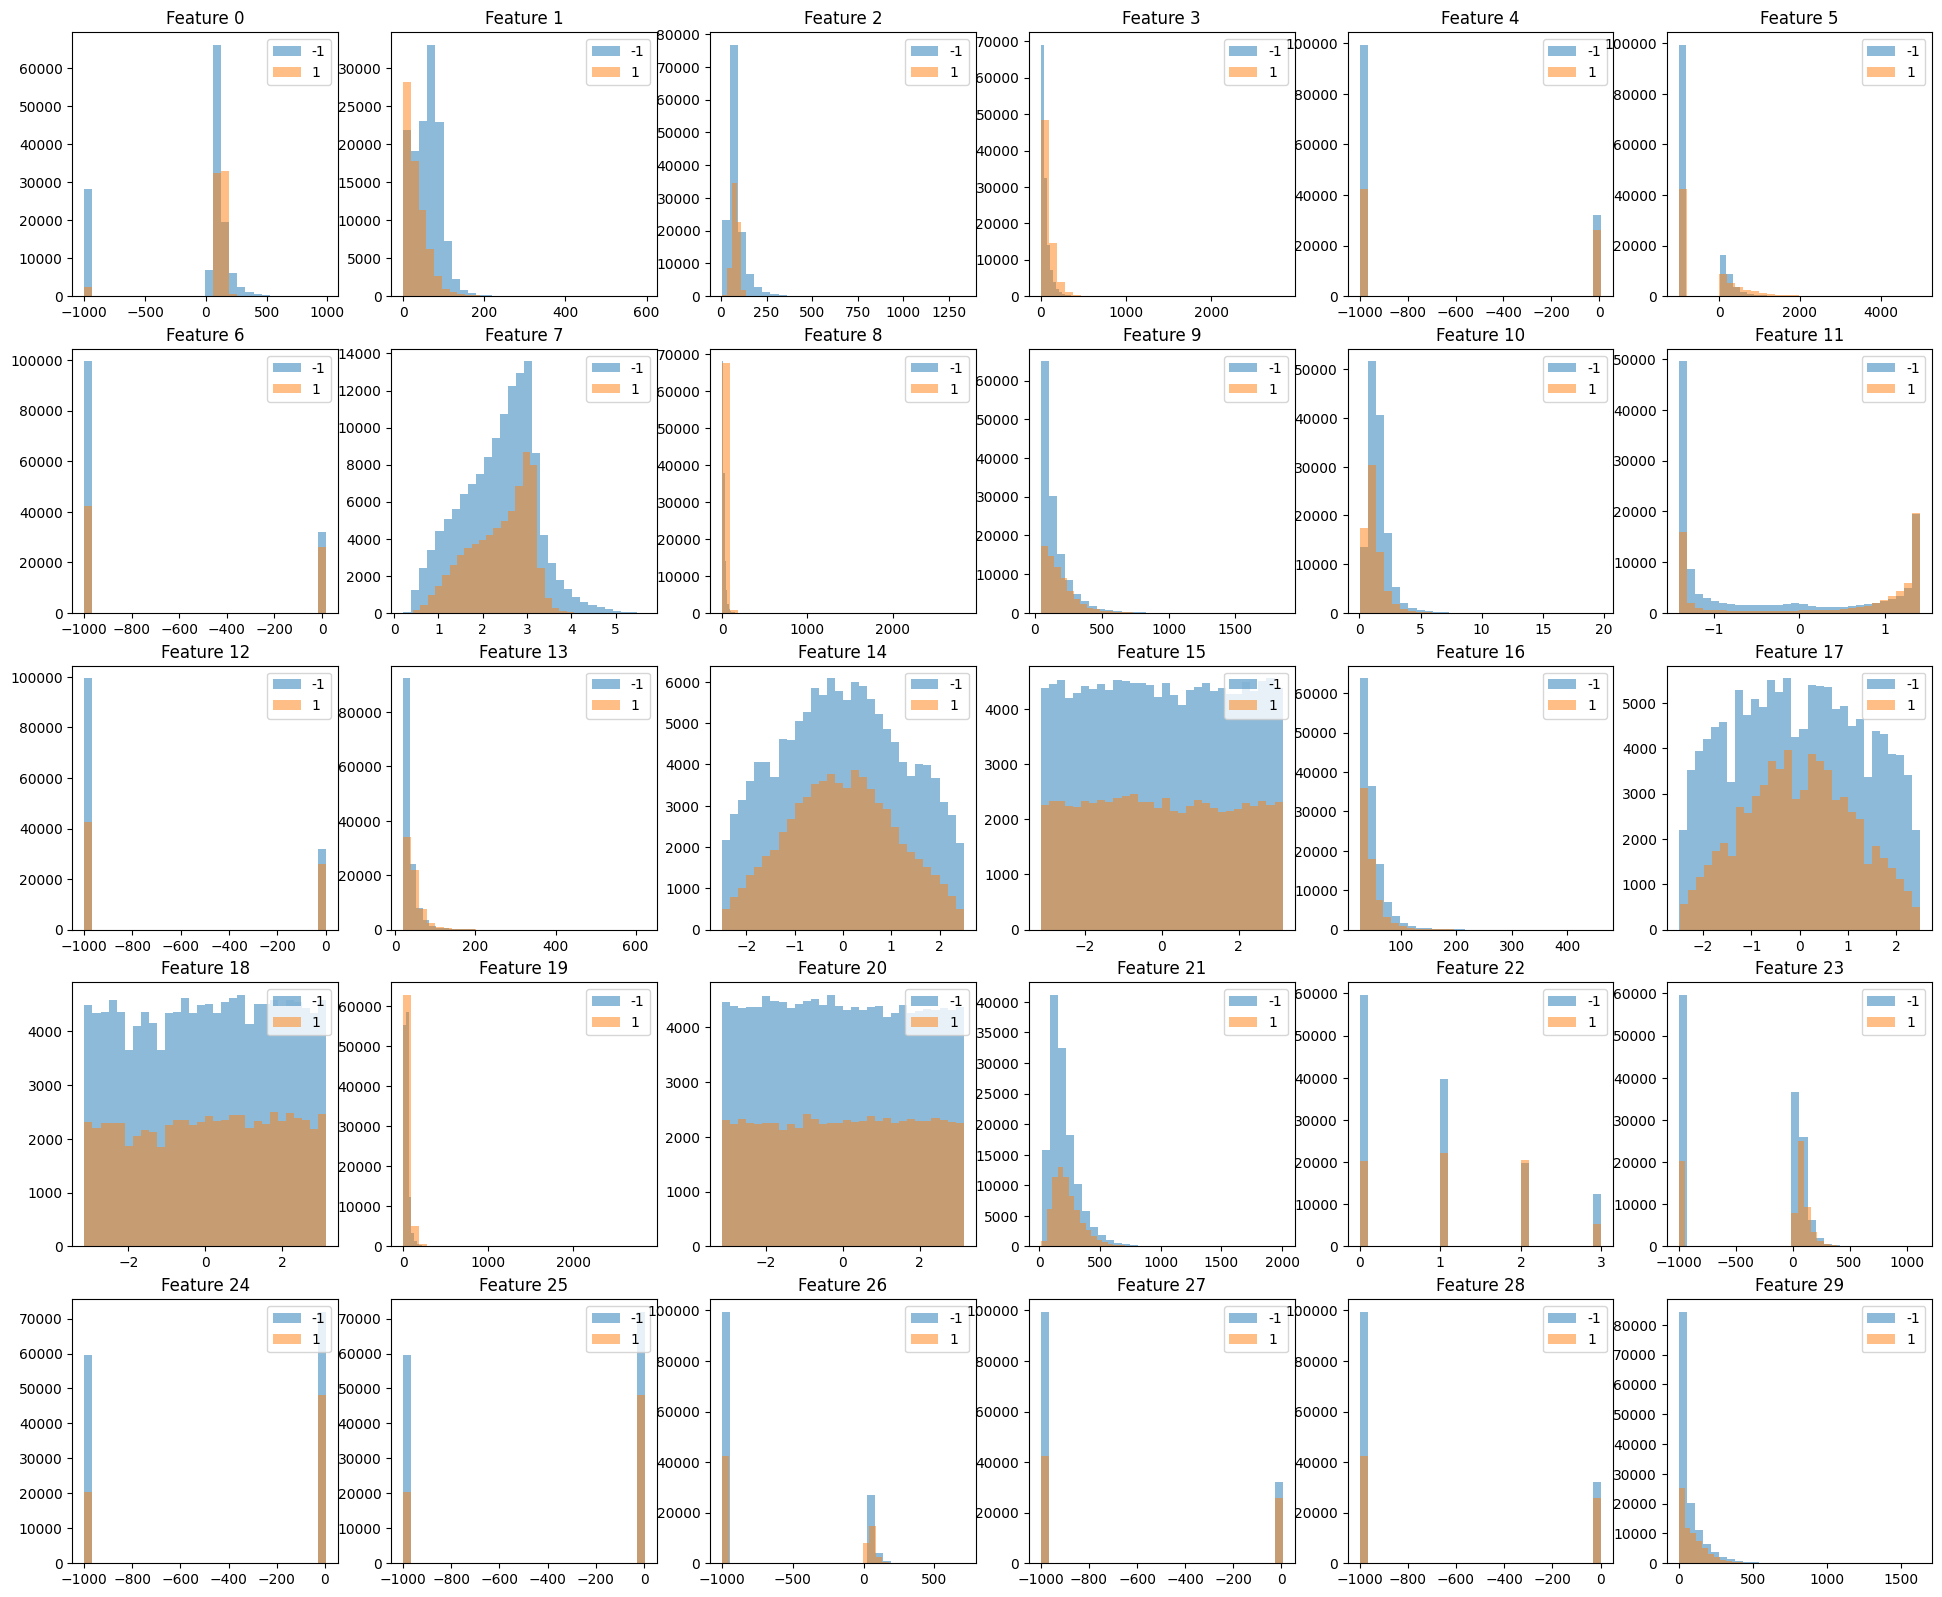

In [3]:
plot_feature_histograms(tx_train, y_train)

In [5]:
from typing import Literal

FEATURES = ('log', 'angles', 'powers', 'products', 'dont_normalize', 'one')
FeatureType = Literal['log', 'angles', 'powers', 'products', 'dont_normalize',
                      'one']


def feature_engineering(tx,
                        mean=None,
                        std=None,
                        enable: Tuple[FeatureType, ...] = True):
    if enable is True:
        enable = FEATURES
    elif enable is False:
        enable = ()

    if 'log' in enable:
        # Some features look like the exponential of some variable, so
        # we add a features that are the log of them
        tx_log = np.log(tx[:, [2, 9, 10, 13, 16, 19, 21]])
        tx = np.concatenate((tx, tx_log), axis=1)

    f_multipliable = [1, 3, 5, 7, 8, 11, 29]
    if 'log' in enable:
        f_multipliable.extend(tx.shape[1] +
                              np.arange(-7, 0))  #[34, 35, 36, 37, 38, 39, 40]

    # We add the powers of each feature for which it makes sense
    if 'powers' in enable:
        powers = [2, 3, 4]
        # features = [1, 2, 3, 5, 7, 8, 9, 10, 11, 13, 16, 19, 21, 29,
        #     34, 35, 36, 37, 38, 39, 40]
        for p in powers:
            tx = np.concatenate((tx, tx[:, f_multipliable]**p), axis=1)

    if 'angles' in enable:
        # Some features are angles, so we add their sine and cosine
        angles = np.array([14, 15, 17, 18, 20])
        tx = np.concatenate((tx, np.sin(tx[:, angles]), np.cos(tx[:, angles])),
                            axis=1)

    # We add the product of each pair of features
    if 'products' in enable:
        for f1 in f_multipliable:
            for f2 in f_multipliable:
                if f1 < f2:
                    tx = np.concatenate((tx, tx[:, [f1]] * tx[:, [f2]]),
                                        axis=1)

    # Normalisation

    assert (mean is None) == (std is None), f"{mean=} {std=}"
    if mean is None:

        mean = np.mean(tx, axis=0)
        std = np.std(tx, axis=0)

        # We don't normalize every feature.
        # We don't normalise features that are discrete, angular
        # Or where the 0 seems to be a special value (f_11)
        if 'dont_normalize' in enable:
            dont_normalise = {11, 14, 15, 17, 18, 20, 22}
            # dont_normalise.update(np.where(np.min(tx_train, axis=0) >= 0)[0])
            dont_normalise = list(dont_normalise)
            mean[dont_normalise] = 0
            std[dont_normalise] = 1

    std[std == 0] = 1  # The feature is constant
    tx = (tx - mean) / std

    # Add a column of ones
    if 'one' in enable:
        tx = np.c_[tx, np.ones(tx.shape[0])]

    return tx, mean, std

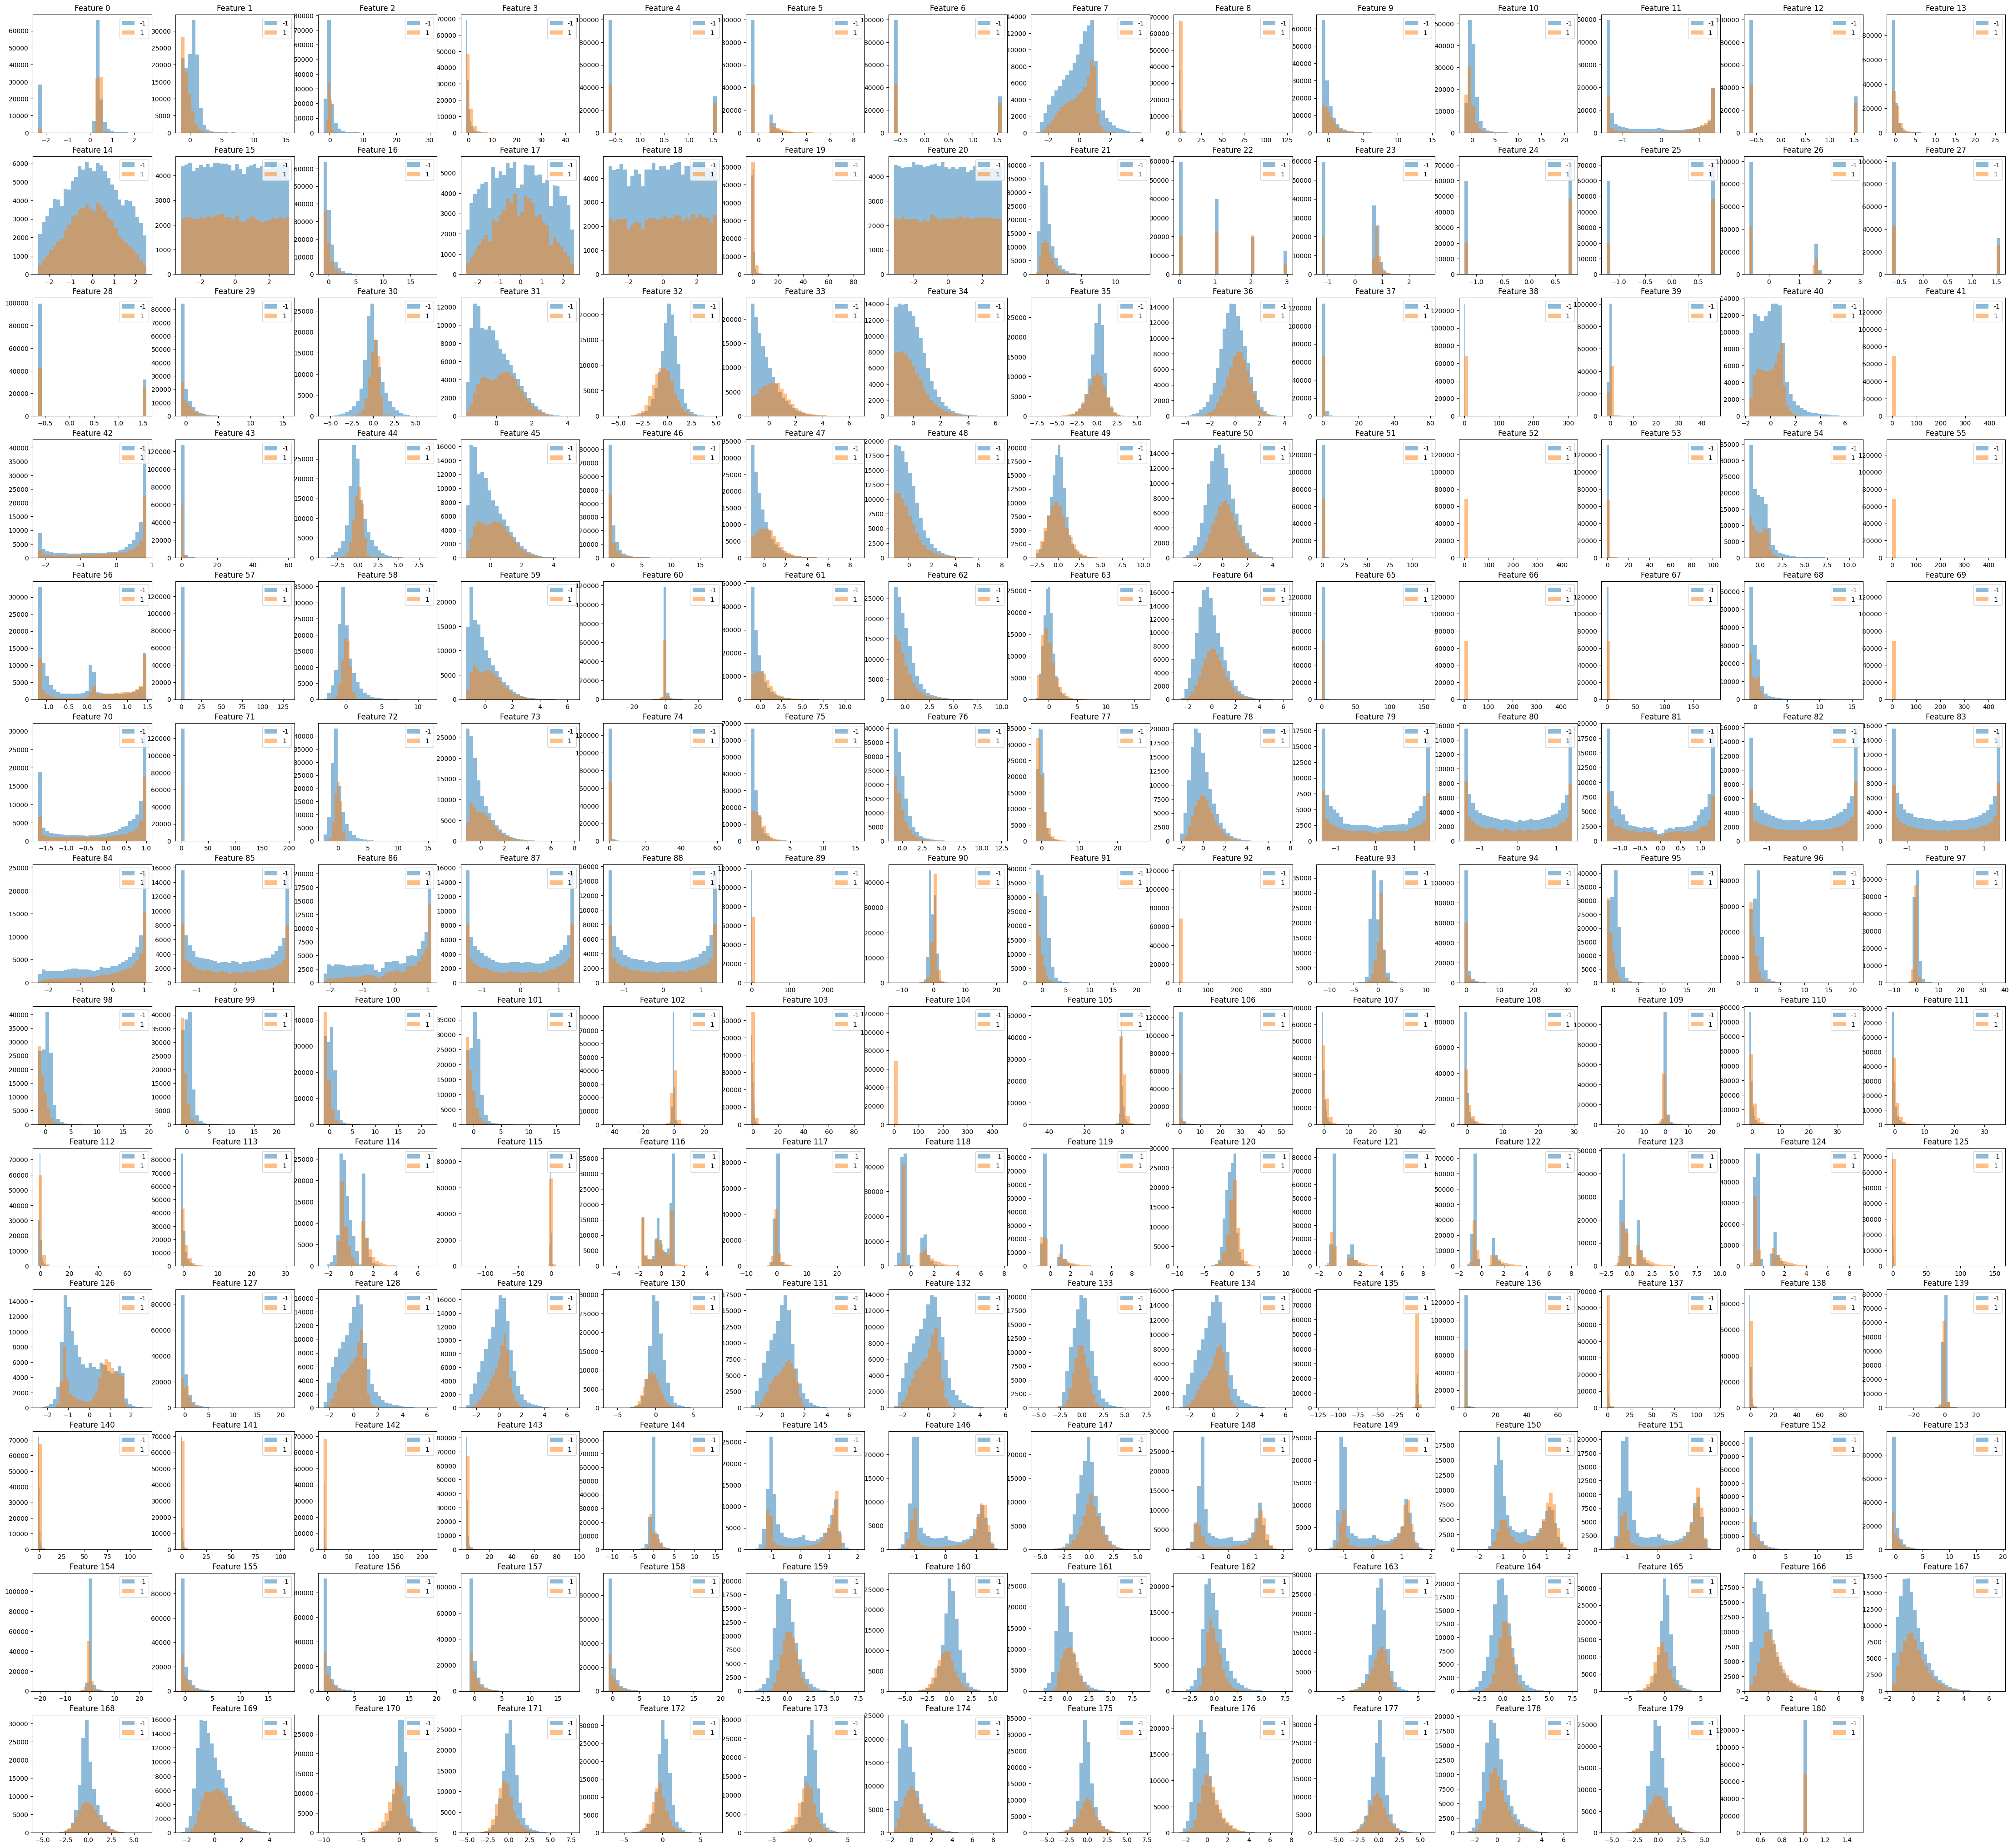

In [6]:
plot_feature_histograms(feature_engineering(tx_train)[0], y_train)

### Outliers

Number of samples above 50 deviations in total: 1825


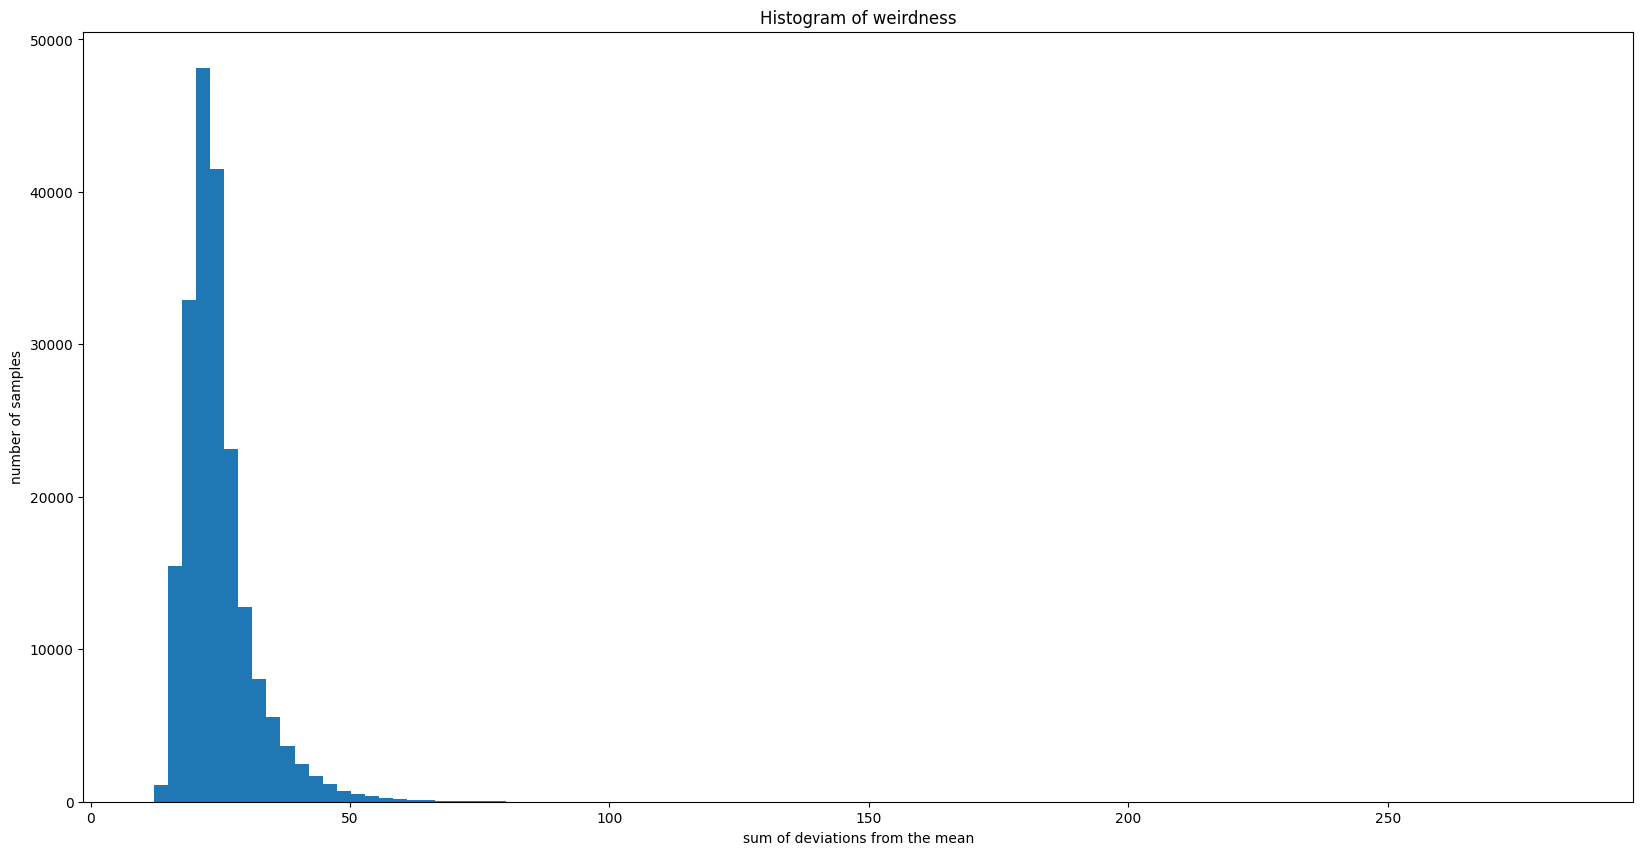

In [7]:
def remove_outliers(tx, y, threshold=50, just_plot=False, enable=True):
    """Remove outliers from the dataset.
    Outliers are defined as points that are more than threshold times the standard
    deviation away from the mean.
    """

    if not enable:
        return tx, y

    weirdness = np.sum(np.abs(normalize_features(tx)[0]), axis=1)

    if just_plot:
        print(
            f'Number of samples above {threshold} deviations in total: {np.sum(weirdness > threshold)}'
        )
        plt.figure(figsize=(20, 10))
        plt.hist(weirdness, bins=100)
        plt.xlabel('sum of deviations from the mean')
        plt.ylabel('number of samples')
        plt.title('Histogram of weirdness')
        plt.show()
    else:
        tx = tx[weirdness < threshold]
        y = y[weirdness < threshold]
        return tx, y


remove_outliers(tx_train, y_train, just_plot=True)


# Training one model

In [17]:
def predict_labels(weights, tx):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.einsum('rf,f->r', tx, weights)
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    return y_pred


def accuracy(y, tx, predictor):
    """Compute the accuracy of the model."""
    y_pred = predictor(tx)
    return np.sum(y_pred == y) / len(y)


def show_accuracy(y, tx, y_test, tx_test, predictor):
    print(f"Accuracy on training set: {accuracy(y, tx, predictor):.4f}")
    print(
        f"Accuracy on test set:     {accuracy(y_test, tx_test, predictor):.4f}"
    )


In [18]:
def pre_process(tx_train,
                y_train,
                tx_test,
                y_test,
                features=True,
                sub_sample=False):
    sub_slice = slice(None, None, 20) if sub_sample else slice(None)

    tx_train, y_train = remove_outliers(tx_train[sub_slice],
                                        y_train[sub_slice],
                                        threshold=50)
    tx_train, mean, std = feature_engineering(tx_train, enable=features)
    tx_test, _, _ = feature_engineering(tx_test[sub_slice],
                                        mean,
                                        std,
                                        enable=features)
    y_test = y_test[sub_slice]

    return y_train, tx_train, y_test, tx_test

In [19]:
data = pre_process(tx_train,
                   y_train,
                   tx_test,
                   y_test,
                   features=True,
                   sub_sample=True)
data_no_features = pre_process(tx_train,
                               y_train,
                               tx_test,
                               y_test,
                               features=False,
                               sub_sample=True)

for d in data:
    print(d.shape)

(9921,)
(9921, 181)
(2500,)
(2500, 181)


In [43]:
def mk_models(data, data_no_features):
    models = {}

    # Ridge
    ridge_w = ridge_regression(data[0], data[1], 1e-6)[0].flatten()
    models['Ridge'] = lambda tx: predict_labels(ridge_w, tx)

    # SGD
    # sgd = mean_squared_error_sgd(data[0], data[1],
    #     max_iters=300, gamma=0.01, lambda_=0.001, batch_size=400,
    #     initial_w=np.random.randn(data[1].shape[1]), verbose=False, clip=True)[0]
    # models['SGD'] = lambda tx: predict_labels(sgd, tx)

    # Background
    models['Background'] = lambda tx: np.full(tx.shape[0], -1)

    # Ridge - no features
    ridge_nof_w = ridge_regression(data_no_features[0][:, None],
                                   data_no_features[1], 1e-6)[0].flatten()
    models['Ridge - no features'] = lambda tx: predict_labels(ridge_nof_w, tx)

    return models

In [44]:
# Average accuracy of models
sub_sample = False
accuracies = defaultdict(list)
for i in tqdm(range(10)):
    split = split_data(tx_loaded, y_loaded, 0.8, seed=i)
    data = pre_process(*split, features=True, sub_sample=sub_sample)
    data_no_features = pre_process(*split,
                                   features=False,
                                   sub_sample=sub_sample)
    models = mk_models(data, data_no_features)
    for name, model in models.items():
        if 'no features' in name:
            accuracies[name].append(accuracy(*data_no_features[2:], model))
        else:
            accuracies[name].append(accuracy(*data[2:], model))

  0%|          | 0/10 [00:00<?, ?it/s]

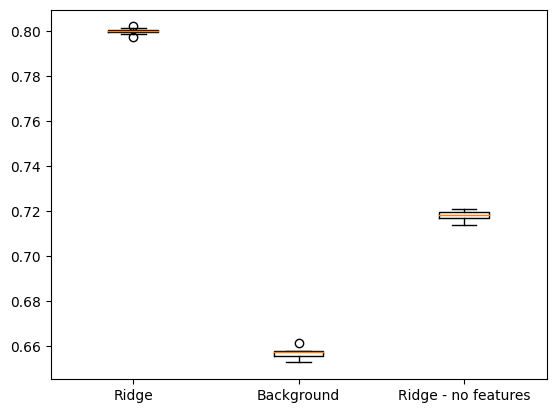

Ridge: 0.8000 ± 0.0013
Background: 0.6567 ± 0.0023
Ridge - no features: 0.7180 ± 0.0020


In [48]:
plt.boxplot(accuracies.values(), labels=accuracies.keys())
plt.show()

for name, acc in accuracies.items():
    print(f'{name}: {np.mean(acc):.4f} ± {np.std(acc):.4f}')

In [ ]:
y_pred = np.einsum('rf,f->r', tx_clean, weight)
# np.clip(y_pred, -1, 1, out=y_pred)
plot_feature_histograms(y_pred[:, None], y_clean)

In [ ]:
plt.figure(figsize=(3, 3))
smooth_loss = np.convolve(losses[1000:], np.ones(1000) / 1000, mode='valid')
plt.plot(np.linspace(0, params['max_iters'], len(smooth_loss)), smooth_loss)
show_accuracy(y_clean, tx_clean, y_test_clean, tx_test_clean,
              lambda tx: predict_labels(weight, tx))


In [ ]:
import itertools


def parameter_search(fixed, **kwargs):
    """Search for the best parameters."""
    keys = list(kwargs.keys())
    values = list(itertools.product(*kwargs.values()))
    results = {}

    best_params = None
    best_accuracy = 0
    for params in tqdm(values):
        params_ = dict(zip(keys, params))
        print(' '.join(f'{k}={v}' for k, v in params_.items()))
        weigth, _ = mean_squared_error_sgd(y_clean,
                                           tx_clean,
                                           **fixed,
                                           **params_,
                                           verbose=False)
        accuracy_ = accuracy(y_test_clean, tx_test_clean,
                             lambda tx: predict_labels(weigth, tx))
        print(f'Accuracy: {accuracy_:.4f} (best: {best_accuracy:.4f})')
        results[params] = accuracy_
        if accuracy_ > best_accuracy:
            best_accuracy = accuracy_
            best_params = params
    return best_params, results


best_params, results = parameter_search(
    {
        'max_iters': 300,
        'batch_size': 100,
        'initial_w': np.random.randn(tx_clean.shape[1])
    },
    gamma=[0.1, 0.05, 0.01, 0.005],
    lambda_=[
        0.1,
        0.001,
        0.0001,
    ])


In [ ]:
def train(
    y_train,
    tx_train,
    features,
    rm_outliers=True,
    sub_sample=True,
):
    sub_slice = slice(None, None, 20) if sub_sample else slice(None)

    tx, y_clean = remove_outliers(tx_train[sub_slice],
                                  y_train[sub_slice],
                                  threshold=50,
                                  enable=rm_outliers)
    tx_clean, mean, std = feature_engineering(tx, enable=features)

    params = {
        'max_iters': 300,
        'gamma': 0.01,
        'lambda_': 0.001,
        'batch_size': 400,
        'initial_w': np.random.randn(tx_clean.shape[1]),
    }
    weigth, _ = mean_squared_error_sgd(y_clean,
                                       tx_clean,
                                       **params,
                                       verbose=False)

    tx_test_clean, _, _ = feature_engineering(tx_test[sub_slice],
                                              mean,
                                              std,
                                              enable=features)
    y_test_clean = y_test[sub_slice]
    accuracy_ = accuracy(y_test_clean, tx_test_clean,
                         lambda tx: predict_labels(weigth, tx))

    return weigth, accuracy_


def features_search(y_train, tx_train, y_test, tx_test):
    results = {}
    for feature_set in itertools.product([1, 0], repeat=len(FEATURES)):
        feature_set = tuple([f for f, b in zip(FEATURES, feature_set) if b])
        # for feature in FEATURES + ("none",):
        #     feature_set = (feature,)
        weight, accuracy_ = train(y_train,
                                  tx_train,
                                  feature_set,
                                  rm_outliers=True,
                                  sub_sample=True)
        results[feature_set] = accuracy_
        print(f'Accuracy: {accuracy_:.4f} features: {feature_set}')
    return results


results = features_search(y_train, tx_train, y_test, tx_test)
results

In [ ]:
options = list(results.keys())
options.sort(key=lambda x: results[x], reverse=True)
for option in options:
    print(f'{(option)}: {results[option]:.4f}')

# Training multiple models
Depending on feature 22

In [ ]:
# Showing accuracy depending on the value of feature 22
for f_22 in range(4):
    mask = tx_clean[:, 22] == f_22
    acc = accuracy(y_clean[mask], tx_clean[mask],
                   lambda tx: predict_labels(weight, tx))
    print(f"Accuracy for f_22 = {f_22}: {acc:.4f} ({np.sum(mask)} samples)")

In [ ]:
models = []
normalisation = []
losses = []
for f_22 in range(4):
    mask = tx_train[:, 22] == f_22

    tx, y_clean = remove_outliers(tx_train[mask],
                                  y_train[mask],
                                  threshold=50,
                                  enable=1)
    tx_clean, mean, std = feature_engineering(tx, enable=True)
    normalisation.append((mean, std))

    # params['initial_w'] = np.random.randn(tx_clean.shape[1], 1)
    # model, loss = mean_squared_error_sgd(y_clean, tx_clean, **params)
    weight, _ = ridge_regression(y_clean[:, None], tx_clean, 0.00001)
    models.append(weight.flatten())
    losses.append(loss)

In [ ]:
for w in models:
    plt.plot(np.sort(w))

In [ ]:
def predict_labels_22(models, tx):
    y_pred = np.zeros(tx.shape[0])
    for f_22, w in enumerate(models):
        mask = tx[:, 22] == f_22
        y_pred[mask] = predict_labels(w, tx[mask])
    return y_pred


# Normalising the test set, but with the 4 different normalisations
def normalise_22(tx, normalisations):
    nb_features = feature_engineering(tx[[0], :])[0].shape[1]
    result = np.zeros((tx.shape[0], nb_features))
    for f_22, (mean, std) in enumerate(normalisation):
        mask = tx[:, 22] == f_22
        result[mask], _, _ = feature_engineering(tx[mask],
                                                 mean,
                                                 std,
                                                 enable=True)
    return result


tx_test_22 = normalise_22(tx_test, normalisation)
tx_train_22 = normalise_22(tx_train, normalisation)
show_accuracy(y_train, tx_train_22, y_test, tx_test_22,
              lambda tx: predict_labels_22(models, tx))


# Predicting the unkown labels

In [ ]:
tx_submission_2 = normalise_22(tx_submission, normalisation)
y_submission = predict_labels_22(models, tx_submission_2)
create_csv_submission(ids_submission, y_submission, "second-attempt.csv")

# Comparision of models

In [ ]:
# comparing the accuracy of the two models, depending on the value of feature 22
for f_22 in range(4):
    mask = tx_test[:, 22] == f_22
    acc_22 = accuracy(y_test[mask], tx_test_22[mask],
                      lambda tx: predict_labels_22(models, tx))
    acc = accuracy(y_test[mask], tx_test_clean[mask],
                   lambda tx: predict_labels(weigths[-1], tx))
    print(
        f"Accuracy for f_22 = {f_22}: {acc_22:.4f} vs {acc:.4f} ({np.sum(mask)} samples)"
    )

# total accuracy
acc_22 = accuracy(y_test, tx_test_22, lambda tx: predict_labels_22(models, tx))
acc = accuracy(y_test, tx_test_clean,
               lambda tx: predict_labels(weigths[-1], tx))
print(f"Total accuracy: {acc_22:.4f} vs {acc:.4f}")

In [ ]:
# Random guessing the prediction
prop_higgs = np.sum(y_train == 1) / y_train.shape[0]
y_pred = np.random.choice([-1, 1],
                          size=y_test.shape[0],
                          p=[1 - prop_higgs, prop_higgs])
show_accuracy(y_test, y_pred, y_test, y_pred, lambda y: y)
print(1 - prop_higgs)
